In [20]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical

In [21]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48, 1))  # 灰階圖的channel數為1
        image_array[i] = image

    return image_array, image_label


def plot_one_emotion_grayhist(data, img_arrays, img_labels, label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion'] == label].index[i]
        axs[i].hist(img_arrays[idx][:, :, 0], 256, [0, 256])
        axs[i].set_title(emotions[img_labels[idx]])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])


def plot_one_emotion(data, img_arrays, img_labels, label=0):
    fig, axs = plt.subplots(1, 7, figsize=(25, 12))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion'] == label].index[i]
        axs[i].imshow(img_arrays[idx][:, :, 0], cmap='gray')
        axs[i].set_title(emotions[img_labels[idx]])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])


def plot_all_emotions(data, img_arrays, img_labels):
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion'] == i].index[0]  # 取該表情的第一張圖的位置
        axs[i].imshow(img_arrays[idx][:, :, 0], cmap='gray')
        axs[i].set_title(emotions[img_labels[idx]])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])


def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

    bar_label = emotions.values()

    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])

    axs[1].bar(bar_label, pred_test_labels[image_number],
               color='orange', alpha=0.7)
    axs[1].grid()

    plt.show()


def plot_compare_distributions(img_labels_1, img_labels_2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = img_labels_1
    df_array2['emotion'] = img_labels_2

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()

    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()

    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()

    plt.show()


emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear',
            3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [22]:
df_raw = pd.read_csv("D:/mycodes/AIFER/data/fer2013.csv")
df_raw.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [23]:
df_raw['Usage'].value_counts()  # 8:1:1

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

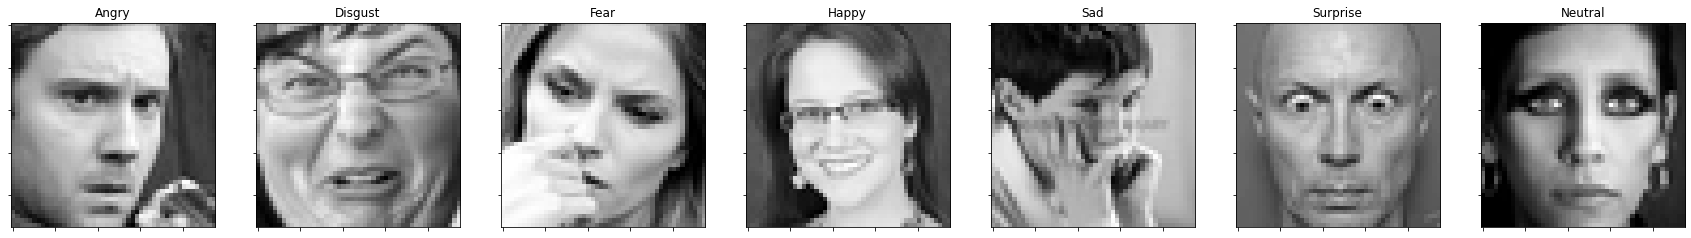

In [24]:
df_train = df_raw[df_raw['Usage'] == 'Training']
df_val = df_raw[df_raw['Usage'] == 'PublicTest']
df_test = df_raw[df_raw['Usage'] == 'PrivateTest']

X_train, y_train = prepare_data(df_train)
X_val, y_val = prepare_data(df_val)
X_test, y_test = prepare_data(df_test)

y_train_oh = to_categorical(y_train)
y_val_oh = to_categorical(y_val)
y_test_oh = to_categorical(y_test)

plot_all_emotions(df_train, X_train, y_train)

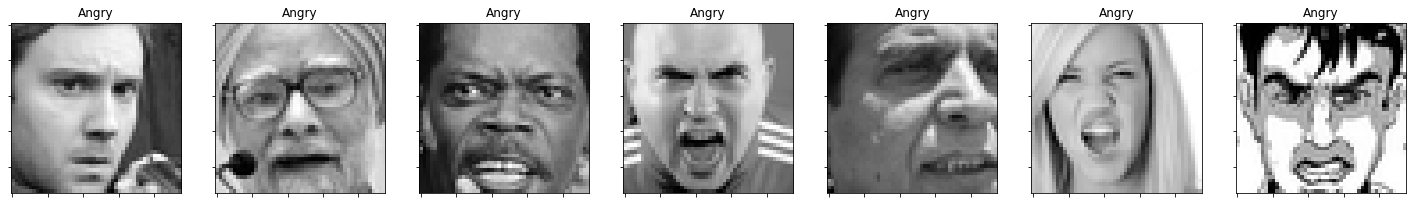

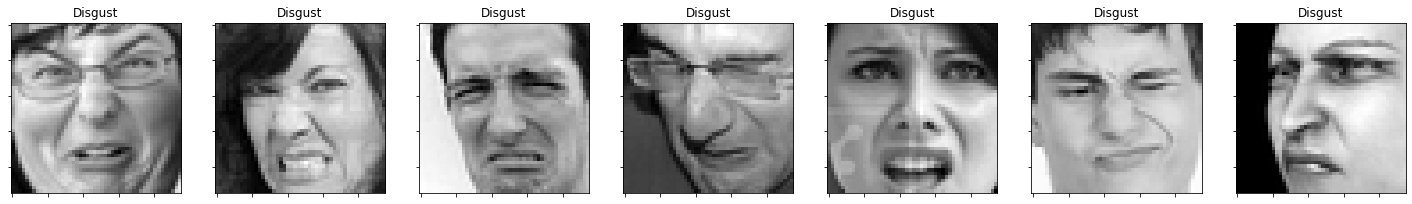

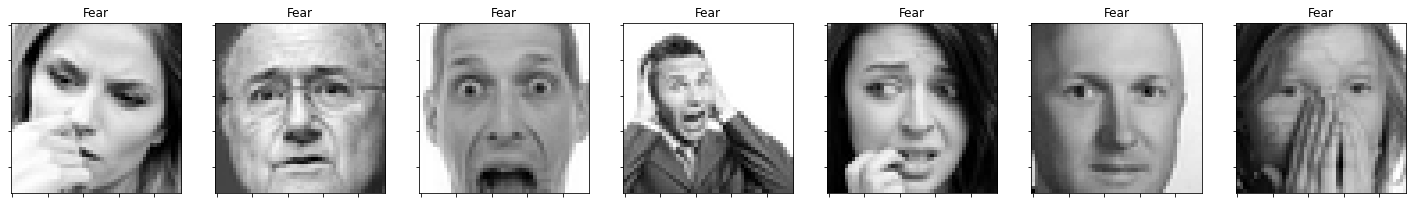

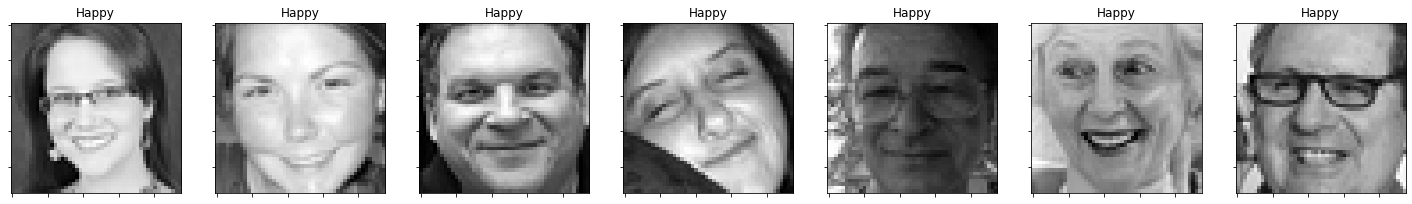

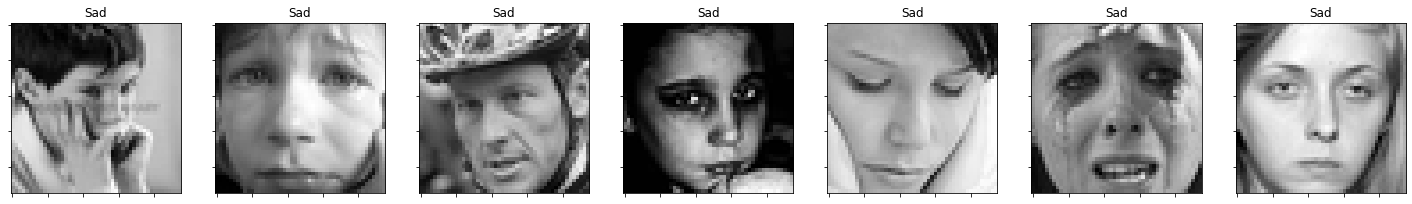

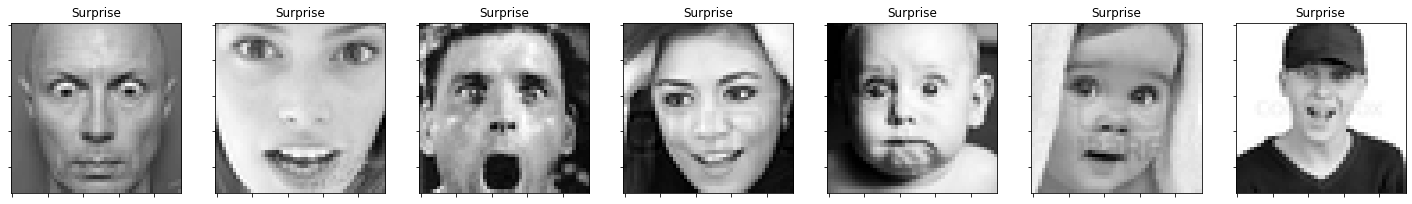

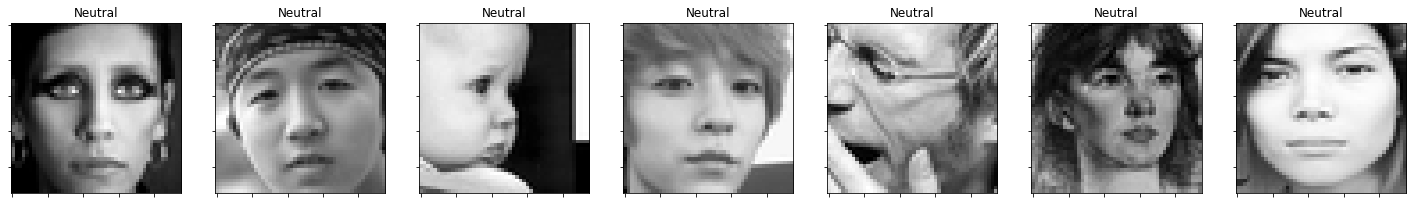

In [25]:
for label in emotions.keys():
    plot_one_emotion(df_train, X_train, y_train, label=label)

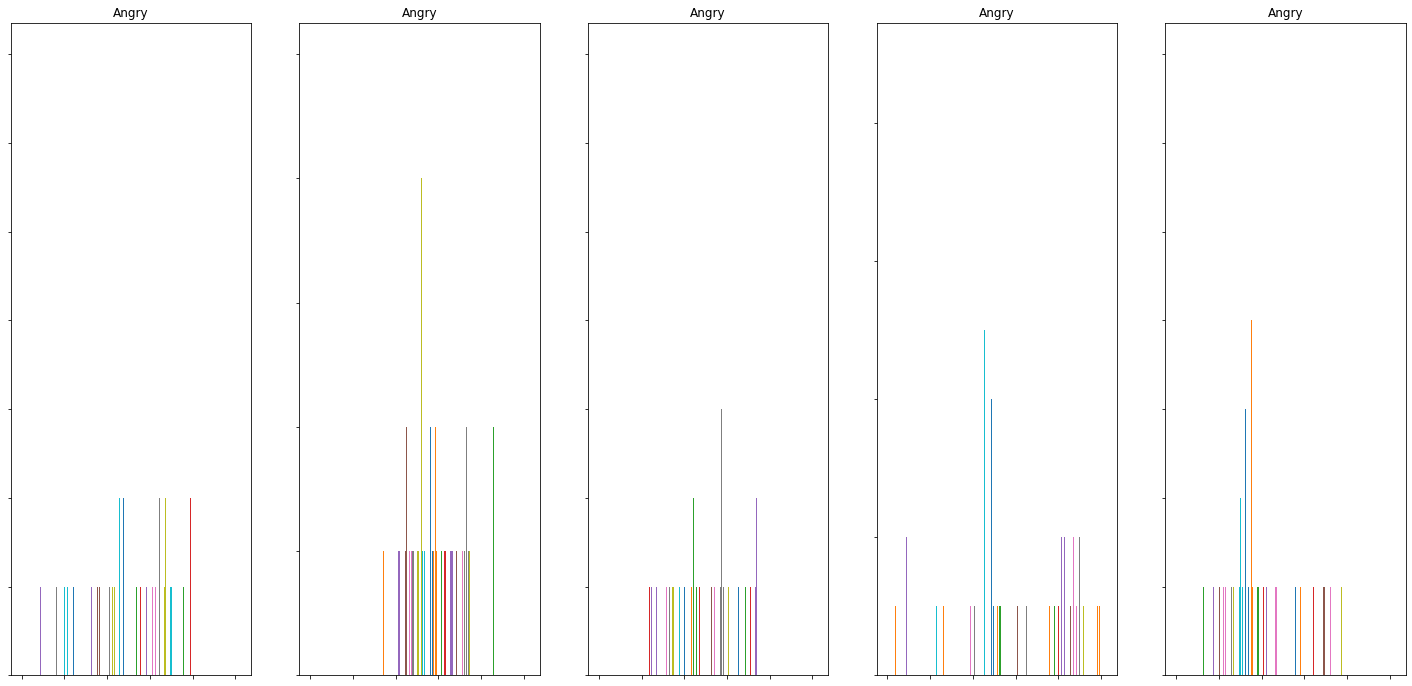

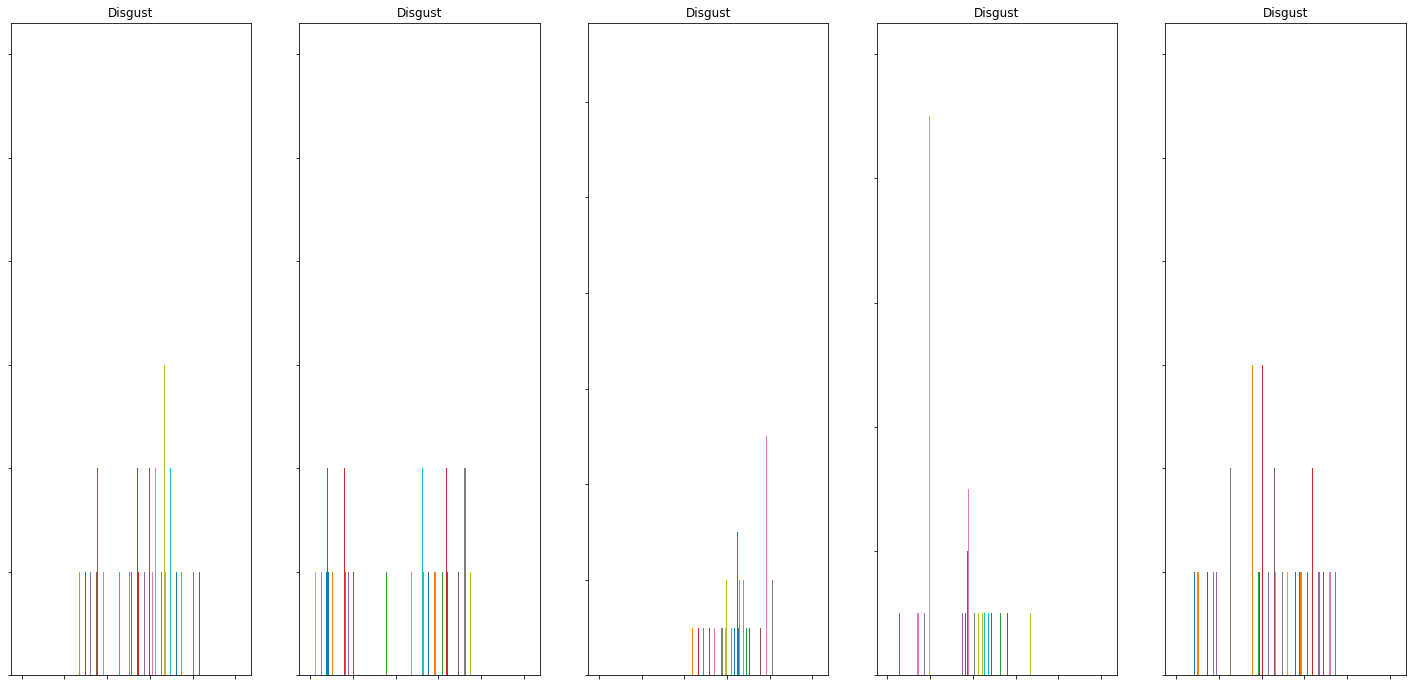

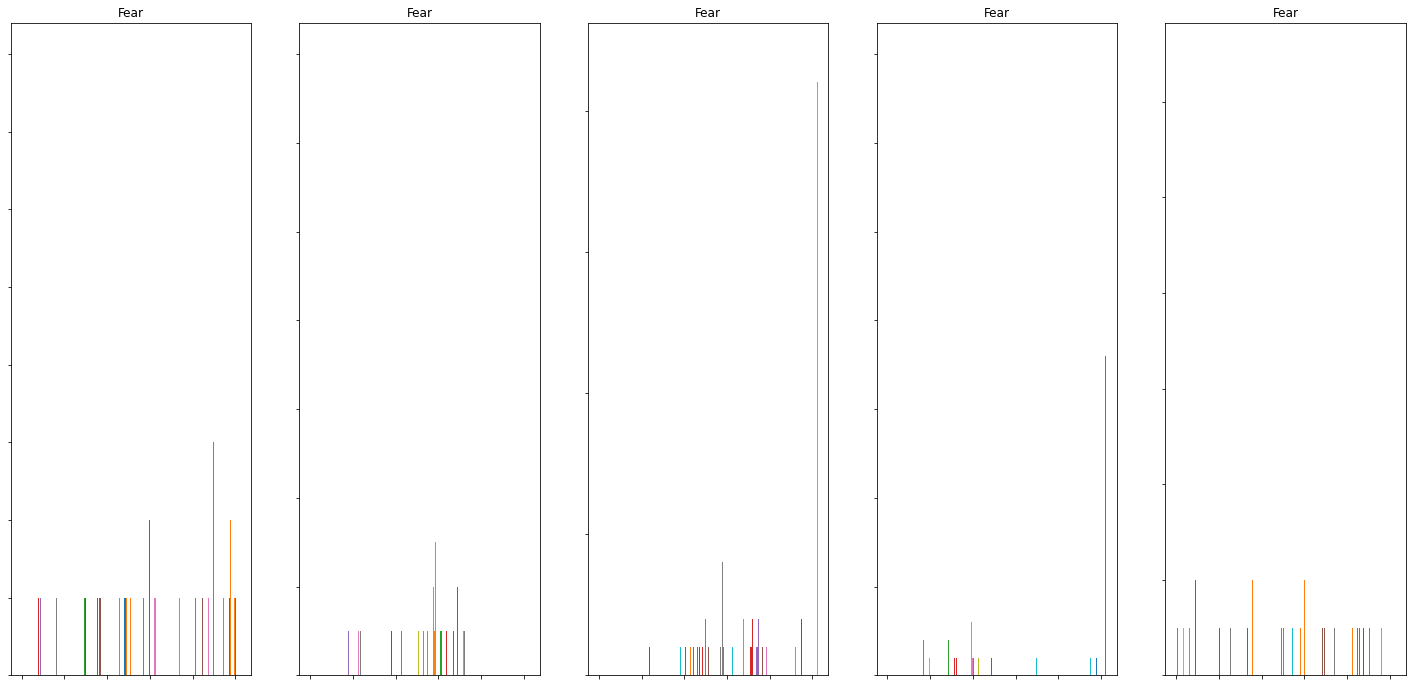

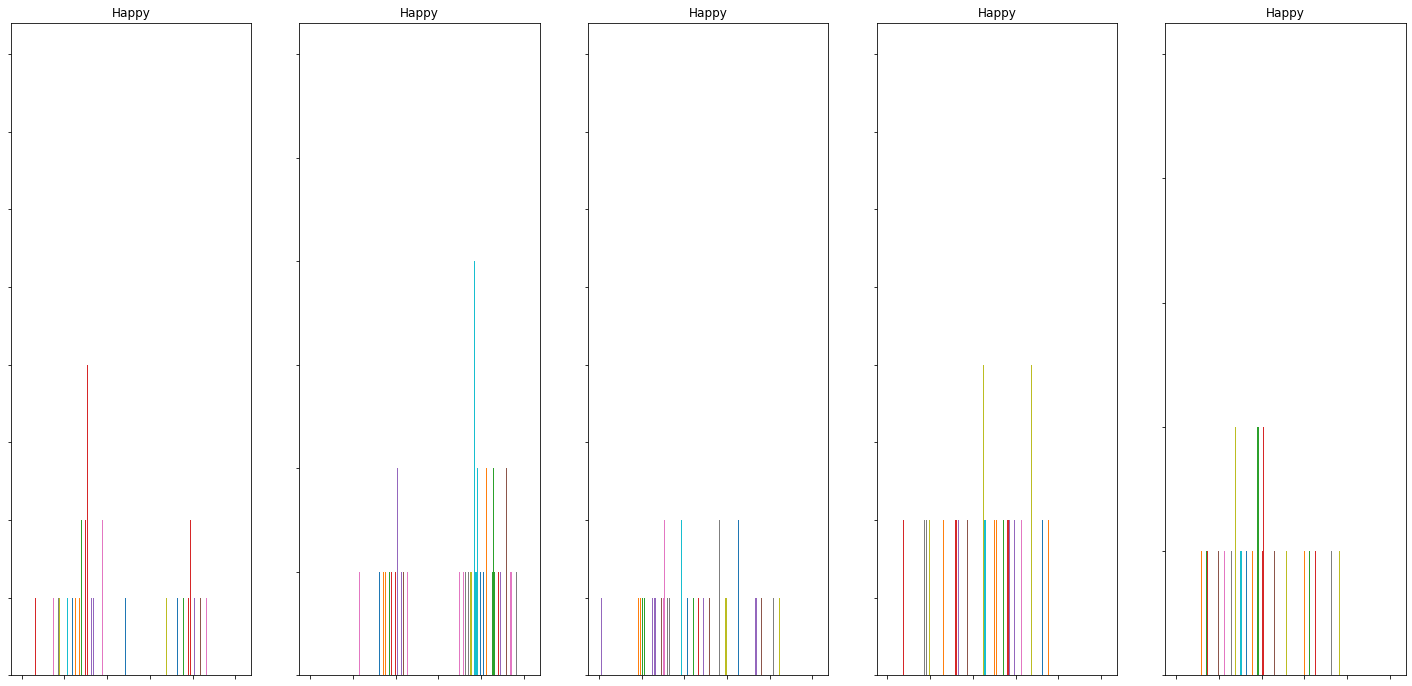

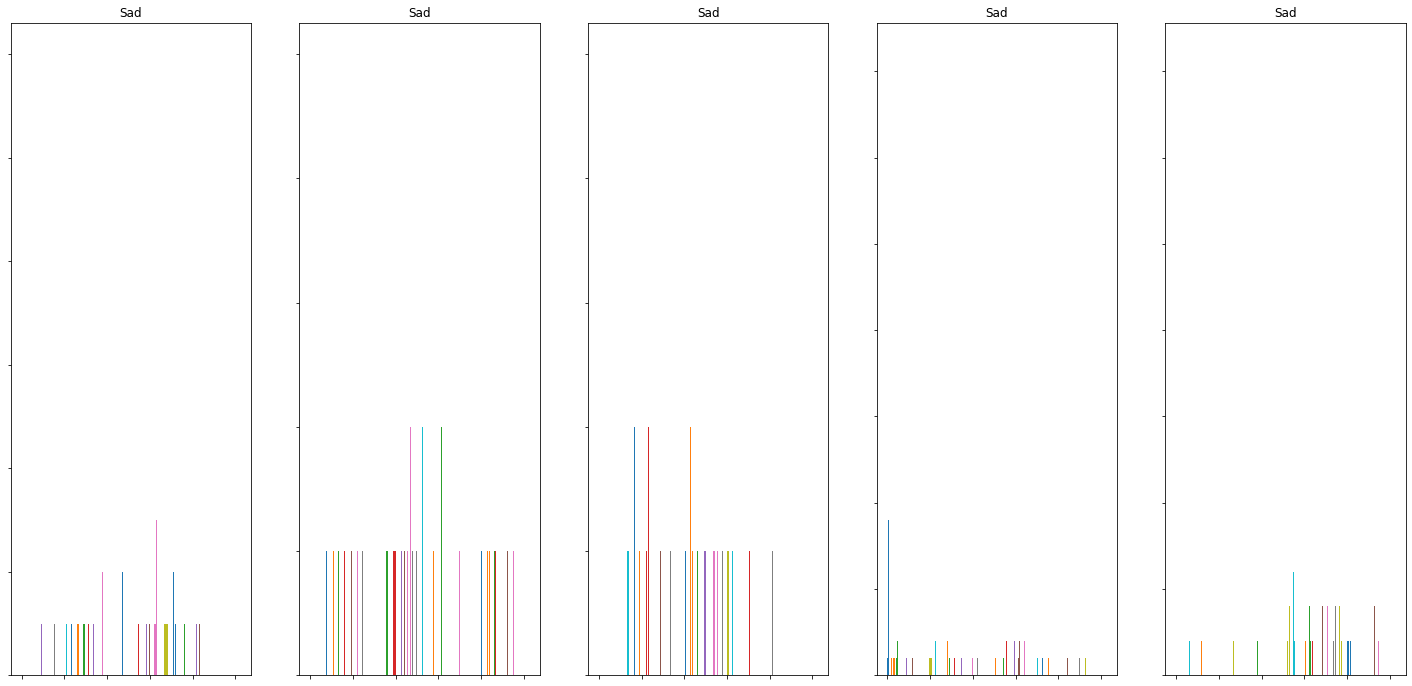

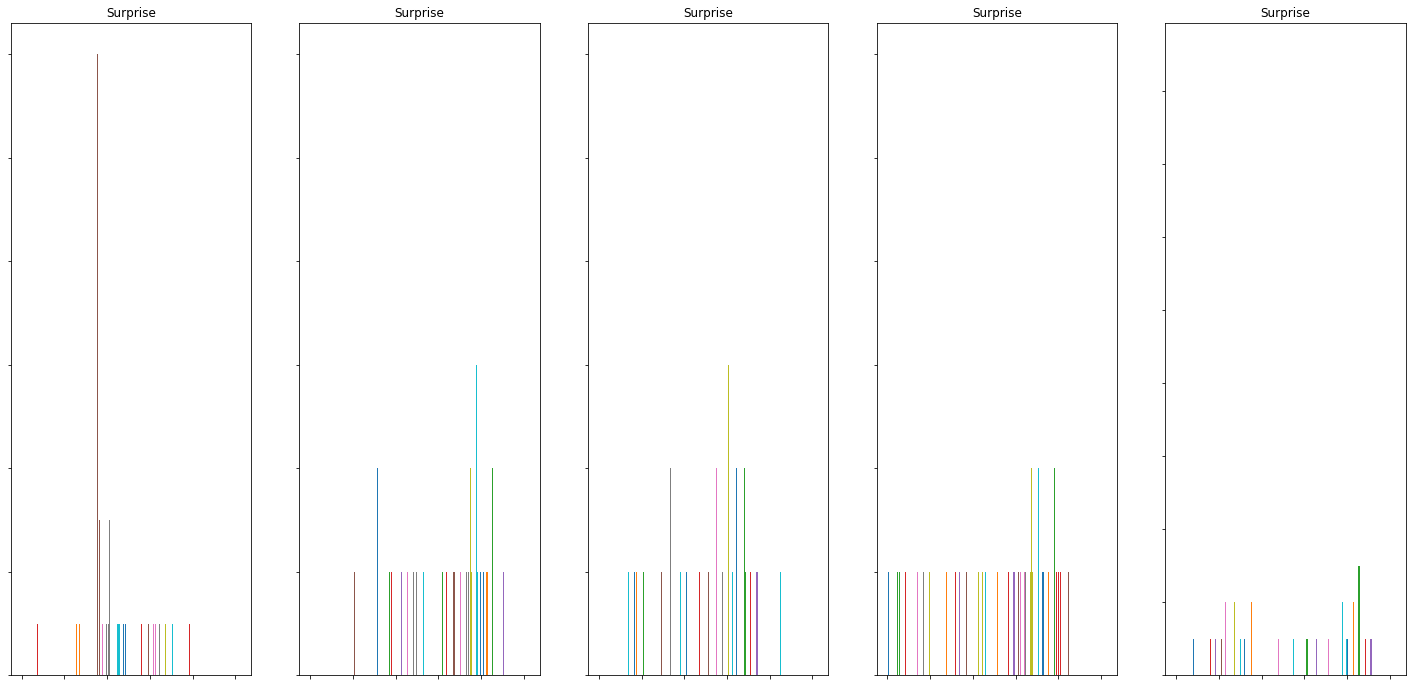

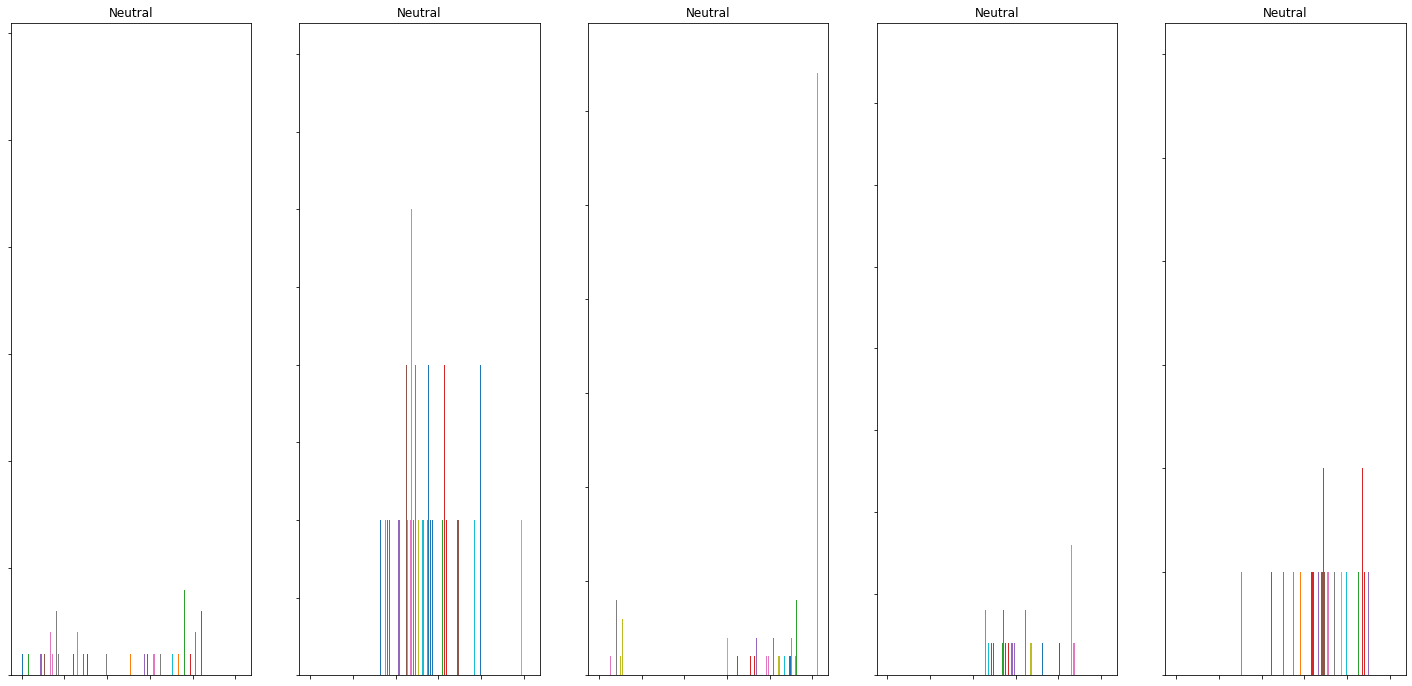

In [26]:
for label in emotions.keys():
    plot_one_emotion_grayhist(df_train, X_train, y_train, label=label)

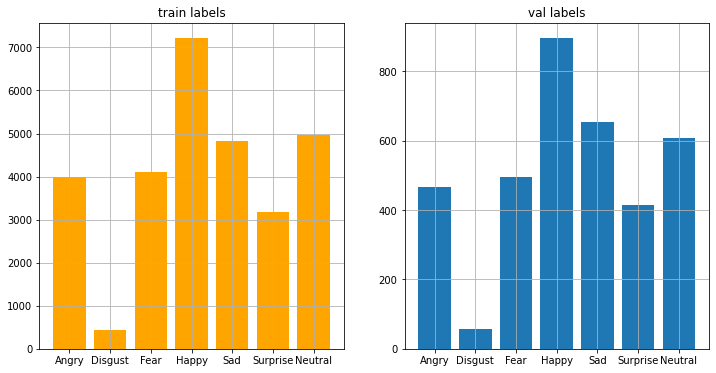

In [27]:
plot_compare_distributions(
    y_train, y_val, title1='train labels', title2='val labels')

In [28]:
n_sample, nrow, ncol, nchannel = X_train.shape

X = X_train.reshape((n_sample, ncol * nrow * nchannel))
pca = PCA(n_components=2, whiten=True)
pca.fit(X)
print(pca.explained_variance_ratio_)
X_pca = pca.transform(X)

[0.28923892 0.09806088]


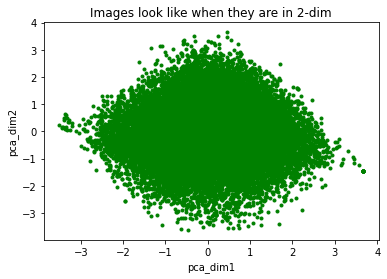

In [29]:
plt.xlabel('pca_dim1')
plt.ylabel('pca_dim2')
plt.title('Images look like when they are in 2-dim')
plt.scatter(X_pca[:, 0], X_pca[:, 1], color='green', marker=".")

In [30]:
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(X_pca)
    kmeans.fit(X_pca)
    distortions.append(sum(np.min(
        cdist(X_pca, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_pca.shape[0])

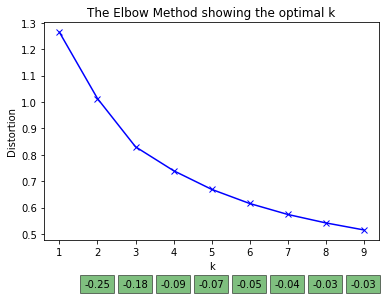

In [31]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
for k in range(1, 9):
    plt.text(k+0.65, 0.3, f"{distortions[k]-distortions[k-1]:.2f}",
             bbox=dict(facecolor='green', alpha=0.5))
plt.show()